# Get crystal structures Metadata from PDB
- This notebook allows to download a pdb id associated metadata.
- The metadata from the pdb ids belonging to the target protein are gathered into a dataframe named: `TABLA_MTDATA_{prot_name}_{number_of_structures}_crys.json` 

In [47]:
from pathlib import Path
from glob import glob
import pandas as pd
import pickle
import json
import sys
sys.path.insert(0, '../..')
from helper_modules.get_pdb_ids_from_uniport import *

## Protein data

### Inputs
This notebook requires to specify the following values
- `prot_name`: the name of the protein.
- `uniprot_id`: Uniprot Accession number.
- `ref_struc_id`: PDB id of the reference structure.
- `ref_ligand_name`: Three letters name of the cocrystalized ligand in the reference structure.


In [48]:
prot_name       = 'fxa'
uniprot_id      = 'P00742'
ref_struc_id    = '1ezq'
ref_ligand_name = 'RPR'

### Get the protein sequence

In [49]:
seq_prot = get_seq_from_uniprot(uniprot_id)
print(seq_prot)
print(f'\nThere are {len(seq_prot)} residues.')

MGRPLHLVLLSASLAGLLLLGESLFIRREQANNILARVTRANSFLEEMKKGHLERECMEETCSYEEAREVFEDSDKTNEFWNKYKDGDQCETSPCQNQGKCKDGLGEYTCTCLEGFEGKNCELFTRKLCSLDNGDCDQFCHEEQNSVVCSCARGYTLADNGKACIPTGPYPCGKQTLERRKRSVAQATSSSGEAPDSITWKPYDAADLDPTENPFDLLDFNQTQPERGDNNLTRIVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQAKRFKVRVGDRNTEQEEGGEAVHEVEVVIKHNRFTKETYDFDIAVLRLKTPITFRMNVAPACLPERDWAESTLMTQKTGIVSGFGRTHEKGRQSTRLKMLEVPYVDRNSCKLSSSFIITQNMFCAGYDTKQEDACQGDSGGPHVTRFKDTYFVTGIVSWGEGCARKGKYGIYTKVTAFLKWIDRSMKTRGLPKAKSHAPEVITSSPLK

There are 488 residues.


### Perform a *blastp* over PDB to get all available structures

### Inputs
This notebook requires to specify the following values
- `prot_name`: the name of the protein.
- `uniprot_id`: Uniprot Accession number.
- `ref_struc_id`: PDB id of the reference structure.
- `ref_ligand_name`: Three letters name of the cocrystalized ligand in the reference structure.


In [50]:
# Get the pdbids and some metadata from uniprot
pdbids_list = pdb_ids_from_uniprot(uniprot_id)
pdbids_list = pdbids_list.pdb_id.to_list()
n_pdb_id    = len(pdbids_list)
# Number of structures found
print(f'{n_pdb_id} pdb entries found!')

136 pdb entries found!


### Get the available metadata

In [51]:
mtdat_json_file = f"./MTDATA_{prot_name.upper()}_{n_pdb_id}_crys.json"

# If the dictionary already exists, load it!
if Path(mtdat_json_file).exists():
    with open(mtdat_json_file, 'r') as file:
        prot_crys_mtd_dict = json.load(file)
# If it does't exist, create it
else:  
    # Create an empty dict to fill it with the pdbs metadata
    prot_crys_mtd_dict = {}
    for pdb_id in pdbids_list[:5]:
        # Get the metadata using pypdb
        descrip_pdb = pypdb.describe_pdb(pdb)
        cristal = pypdb.get_entity_info(pdb)
        ligando = pypdb.get_ligands(pdb)['ligandInfo']
        secuencia = pdbids[pdb]
        # Find number of gaps and coverage 
        # with regards the Uniprot sequence
        seq_alg, coverage, gaps = get_gaps_and_coverage(
                                    pdb_file = f'{pdb_id}', 
                                    full_sequence = seq_prot,
                                    chain = 'A')
        if ligando:
            ligando = ligando['ligand']
            if isinstance(ligando, dict): 
                # If it returns a dictionary, 
                # there will be only one ligand
                ligando = [ligando]
            num_ligs = len(ligando)
            # Create a list with the name of the ligands
            ligs_names = [ligando[mol]['@chemicalID'] 
                          for mol in range(num_ligs)]
        else:
            ligs_names = []
            num_ligs = 0
        prot_crys_mtd_dict.update(
            {pdb : 
                 {'describe_pdb': descrip_pdb, 
                  'pdb_info': cristal, 
                  'ligs': ligando,       
                  'num_ligs': num_ligs, 
                  'name_ligs': ligs_names,
                  'seq': secuencia,
                  'seq_alg': seq_alg, 
                  'coverage': covertura,
                  'gaps': gaps
                 }
            })
    # Save the dict as a json file
    with open(mtdat_json_file, 'w') as file:
        json.dump(file, prot_crys_mtd_dict)

#### Visualize the `1EZQ` entry metadata
- Just an example of the metadata retrieved for a given pdb id. This example is not shown in the EGFR and HSP90 notebooks.

In [52]:
prot_crys_mtd_dict[ref_struc_id]

{'describe_pdb': {'relatedPDB': [{'@pdbId': '1F0R',
    '@details': 'human coagulation factor Xa with inhibitor RPR208815'},
   {'@pdbId': '1F0S',
    '@details': 'human coagulation factor Xa with inhibitor RPR208707'},
   {'@pdbId': '1F0T',
    '@details': 'bovine pancreatic trypsin with inhibitor RPR131247'},
   {'@pdbId': '1F0U',
    '@details': 'bovine pancreatic trypsin with inhibitor RPR128515'}],
  'structureId': '1EZQ',
  'title': 'CRYSTAL STRUCTURE OF HUMAN COAGULATION FACTOR XA COMPLEXED WITH RPR128515',
  'pubmedId': '10966741',
  'expMethod': 'X-RAY DIFFRACTION',
  'resolution': '2.20',
  'keywords': 'HYDROLASE',
  'nr_entities': '2',
  'nr_residues': '388',
  'nr_atoms': '2262',
  'deposition_date': '2000-05-11',
  'release_date': '2000-09-20',
  'last_modification_date': '2017-10-04',
  'structure_authors': 'Maignan, S., Guilloteau, J.P., Pouzieux, S., Choi-Sledeski, Y.M., Becker, M.R., Klein, S.I., Ewing, W.R., Pauls, H.W., Spada, A.P., Mikol, V.',
  'citation_authors': 

## Create the final Metadata table

In [53]:
def get_data_rows(pdb_entry: dict) -> pd.Series:
    '''
    This function takes a pdb_entry dictionary, 
    nested in `prot_crys_mtd_dict` created in the previous cell,
    and returns a pandas series containing the entry metadata
    '''
    e = pdb_entry
    d = e['describe_pdb']
    s = e['seq']
    l = e['ligs']

    dic = {"PDB_ID"    : d['structureId'].lower(),
          "Title"      : d['title'].lower(),
          "Entities"   : d['nr_entities'],
          "ChainID"    : e['chain_id'],
          "Identity"   : '-',
          "Coverage"   : e['covertura'],
          "NumGaps"    : e['gaps']['num_gaps'],
          "GapLen"     : e['gaps']['gap_lengths'],
          "GapPos"     : e['gaps']['gap_list'],
          "Resolution" : d['resolution'],
          "Date"       : d['release_date'],
          "NumLigs"    : e['num_ligs'], 
          "NameLigs"   : e['name_ligs']
          }
    entry_series = pd.Series(dic)
    return entry_series

def get_mtd_table(dic: dict):
    '''
     This function is designed to take the 
     `prot_crys_mtd_dict` dictionary
     and extract a pandas series for each pdb entry
    '''
    df = pd.DataFrame()
    for pdb_id in dic.keys():
        row = get_data_rows(dic[pdb_id])
        df = df.append(row, ignore_index=True)
    return df

In [54]:
# Now we create the dataframe
df_prot = get_mtd_table(prot_crys_mtd_dict).sort_values("PDB_ID").set_index("PDB_ID")

# Reorder the columns
df_prot = df_prot[['Title','Date', 'Entities', 'ChainID','Resolution', 
         'Identity', 'Coverage', 'NumGaps', 'GapLen', 'GapPos',
         'NumLigs', 'NameLigs']]
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1c5m,structural basis for selectivity of a small mo...,2000-12-22,2,D,1.95,-,49.385246,2.0,"[235, 14]","[[1, 235], [475, 488]]",0.0,[]
1ezq,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.20,-,47.950820,2.0,"[235, 21]","[[1, 235], [469, 489]]",2.0,"[CA, RPR]"
1f0r,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2.0,"[235, 21]","[[1, 235], [469, 489]]",2.0,"[815, CA]"
1f0s,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2.0,"[235, 21]","[[1, 235], [469, 489]]",2.0,"[CA, PR2]"
1fax,coagulation factor xa inhibitor complex,1997-10-29,2,A,3.00,-,48.155738,2.0,"[235, 20]","[[1, 235], [470, 489]]",2.0,"[CA, DX9]"


## Save the metadata Dataframe to a file

In [55]:
n_pdb_id_to_use = len(df_prot)
dataframe_file = f"./TABLA_MTDATA_{prot_name.upper()}_{n_pdb_id_to_use}_crys.json"
if not Path(dataframe_file).exists:
    df_prot.to_json(dataframe_file)

## Data exploration

In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2, style = 'white')

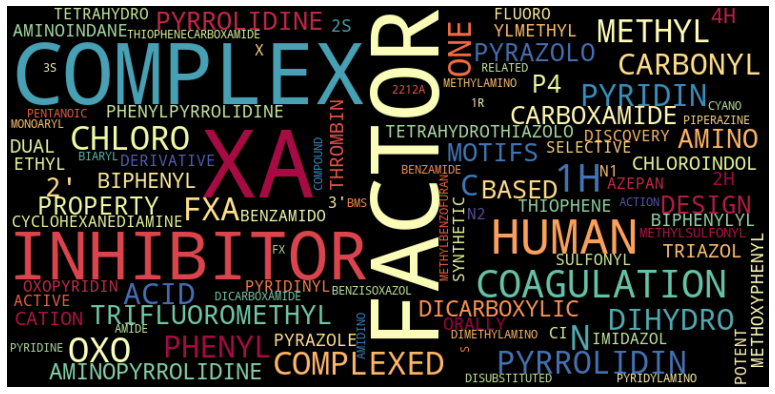

In [57]:
text = " ".join(titulo for titulo in df_prot.Title)
text = text.replace('-', ' ').upper()

stopwords = set(STOPWORDS)
stopwords.update([ "structure", "ray", "crystal", "yl"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, 
                      max_font_size = 100, 
                      collocations = False, 
                      min_font_size = 4,
                      contour_width = 100, 
                      colormap = "Spectral", 
                      random_state = 15,
                      max_words = 100, 
                      width=800, height=400,
                      background_color = "black").generate(text)

plt.figure(figsize = (16, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [58]:
def plot_property(prop, color = 'red', title = ''):
    df_prot[prop] = df_prot[prop].astype(float)
    fig, ax = plt.subplots(figsize = (8, 5))
    sns.histplot(df_prot[prop] , 
                 color = color, 
                 kde = True,
                 label = prop,
                 ax = ax)
    plt.legend()
    plt.title(title)
    plt.show()

[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of structures published by year')]

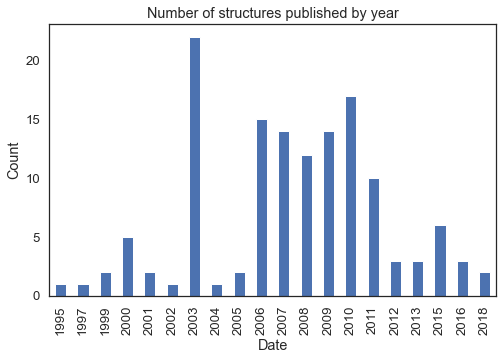

In [59]:
df_prot.Date = pd.to_datetime(df_prot.Date)
df_prot_dates = df_prot.set_index('Date')
df_prot_dates.tail()
fig, ax = plt.subplots(figsize = (8, 5))
ax = df_prot.groupby(df_prot.Date.dt.year)['Date'].count().plot(kind='bar')
ax.set(ylabel = 'Count', title = 'Number of structures published by year')

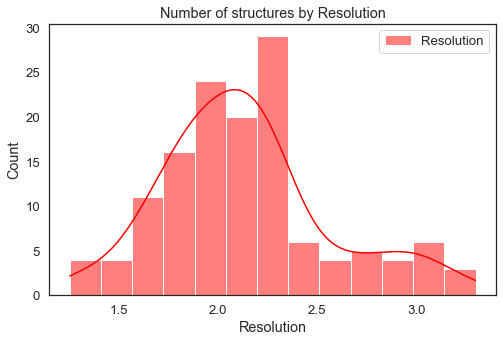

In [60]:
prop = 'Resolution'
plot_property(prop, title = f'Number of structures by {prop}')

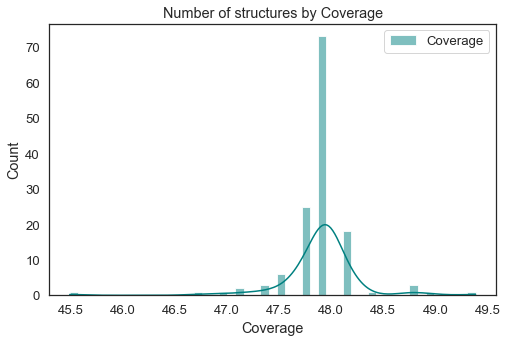

In [61]:
prop = 'Coverage'
plot_property(prop, color = 'teal',
             title = f'Number of structures by {prop}')

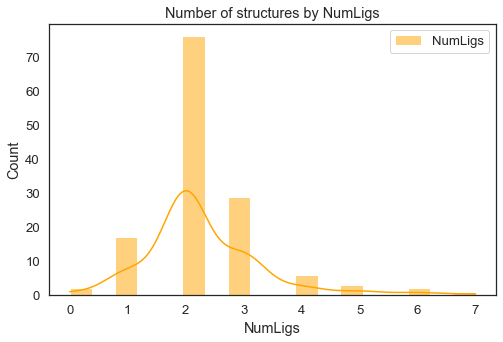

In [62]:
prop = 'NumLigs'
plot_property(prop, color = 'orange',
              title = f'Number of structures by {prop}')